(5625, 135)


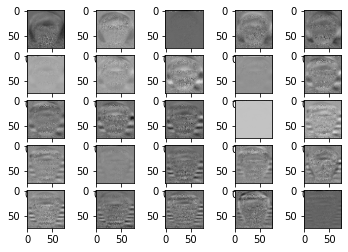

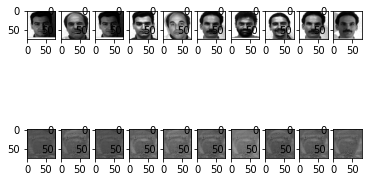

In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2 as cv
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist,squareform
#----------------------------------------------------------------
def dataloader(path,H,W):
    pictures = os.listdir(path)
    images = np.zeros((H*W,len(pictures)))
    labels = np.zeros(len(pictures))
    for i,picture in zip(np.arange(len(pictures)),pictures):
        labels[i] = int(picture.split('.')[0][7:9])-1
        image = np.asarray(Image.open(os.path.join(path,picture)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i] = image
    return images , labels
#----------------------------------------------------------------
def show_eigenfaces(eigenfaces,num,H,W):
    n = int(num**0.5)
    for i in range(num):
        plt.subplot(n,n,i+1)
        plt.imshow(eigenfaces[:,i].reshape(H,W),cmap='gray')
    plt.savefig("fisherfaces.png")
    plt.show()
#----------------------------------------------------------------
def reconstruct(X,X_recover,number,H,W):
    choose = np.random.choice(X.shape[1],number)
    for i in range(number):
        plt.subplot(2,number,i+1)
        plt.imshow(X[:,choose[i]].reshape(H,W),cmap='gray')
        plt.subplot(2,number,i+1+number)
        plt.imshow(X_recover[:,choose[i]].reshape(H,W),cmap='gray')
    plt.savefig("fisherfaces_reconstruct.png")
    plt.show()
#----------------------------------------------------------------
def pca(X,dim):
    #https://blog.csdn.net/hustqb/article/details/78394058
    #https://blog.csdn.net/zouxy09/article/details/45276053 can know by xT*x get xxT eigenvectors
    X_mean = np.mean(X,axis=1).reshape(-1,1)
    X_cor  = X-X_mean
    print("Raw data X is",X.shape)
    print("X_mean is ",X_mean.shape)
    print("X_cor is ",X_cor.shape)
    X_corvariance  = np.dot(X_cor.T,X_cor)
    print("X_corvariance is",X_corvariance.shape)
    eigenvalues , eigenvectors = np.linalg.eig(X_corvariance)
    sort_index = np.argsort(-eigenvalues)
    sort_index = sort_index[:dim]
    
    eigenvalues = eigenvalues[sort_index]
    eigenvectors = np.dot(X_cor,eigenvectors)
    eigenvectors = eigenvectors[:,sort_index]
    eigenvectors_normalize = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors=eigenvectors/eigenvectors_normalize
    eigenfaces = eigenvectors
    print("eigenfaces is",eigenvectors.shape)  #45045*30
    
    pca_data = np.dot(eigenvectors.T,X_cor)
    print("pca_data",pca_data.shape)
    
    return eigenvalues,eigenfaces,X_mean , pca_data

#----------------------------------------------------------------
def lda(x,y,dim):
    #https://blog.csdn.net/kuweicai/article/details/79330524
    #https://blog.csdn.net/matrix_space/article/details/51375691
    #https://blog.csdn.net/SongGu1996/article/details/99560964 it has multiple situation
    N = x.shape[0]
    X_mean = np.mean(x,axis = 1).reshape(-1,1)
    
    classes_mean = np.zeros((N,15))
    count_class = []
    for i in range(15):
        class_blong_tuple = np.where(y == i)
        class_blong=[]
        count = 0
        for j in class_blong_tuple:
            for k in j:
                k = int(k)
                class_blong.append(k)
        for j in range(len(class_blong)):
            classes_mean[:,i]  = classes_mean[:,i] + x[:,class_blong[j]]
            count = count +1
        classes_mean[:,i] = classes_mean[:,i] / count
        count_class.append(count)
    
    #S_W within-class
    S_W = np.zeros((N,N))
    for i in range(15):
        class_blong_tuple = np.where(y == i)
        class_blong=[]
        count = 0
        for j in class_blong_tuple:
            for k in j:
                k = int(k)
                class_blong.append(k)
        for j in range(len(class_blong)):
            temp = x[:,class_blong[j]].reshape(-1,1)-classes_mean[:,i].reshape(-1,1)
            S_W  = S_W + np.dot(temp,temp.T)

    
    #S_B between-class
    S_B = np.zeros((N,N))
    for i in range(15):
        temp = classes_mean[:,i].reshape(-1,1)-X_mean
        S_B =S_B + np.dot(temp,temp.T) * count_class[i]

    
    eigenvalues , eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S_W),S_B))
    sort_index = np.argsort(-eigenvalues)
    sort_index = sort_index[:dim]
    
    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')
    
    return eigenvalues , eigenvectors , X_mean
#----------------------------------------------------------------   
#----------------------------------------------------------------

if __name__ == '__main__':
    filepath = "./Yale_Face_Database/Training"
    H=75
    W=75
    dim = 25
    number = 10
    X_train,y_train = dataloader(filepath,H,W)
    print(X_train.shape)
    
    eigenvalues_lda , eigenvectors_lda , X_mean = lda(X_train,y_train,dim)
    eigenfaces_lda = eigenvectors_lda


    show_eigenfaces(eigenfaces_lda,25,H,W)
    
    lda_data = np.dot(eigenfaces_lda.T,X_train)
    
    X_recover = np.dot(eigenfaces_lda,lda_data)
    reconstruct(X_train,X_recover,number,H,W)

In [2]:
def testing(X_test,y_test,pca_train,y_train,eigenvectors,X_mean,k):
    
    pca_test = np.dot(eigenvectors.T,X_test)
    print("pca_test shape",pca_test.shape)
    
    #k-nn
    test_predict = np.zeros(pca_test.shape[1])
    for i in range(pca_test.shape[1]):
        distance = np.zeros(pca_train.shape[1])
        for j in range(pca_train.shape[1]):
            distance[j] = np.sum(np.square(pca_test[:,i]-pca_train[:,j]))
        sort_index = np.argsort(distance)
        closet_neightbor = y_train[sort_index[:k]]
        unique , counts = np.unique(closet_neightbor,return_counts=True)

        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        test_predict[i] = nearest_neighbors[0]
    
    accuracy = np.count_nonzero((y_test-test_predict)==0)/len(y_test)    
    return accuracy 

if __name__ == '__main__':
    #test and calculate accuracy
    filepath = "./Yale_Face_Database/Testing"
    k=5
    X_test , y_test = dataloader(filepath,H,W)
    accuracy = testing(X_test,y_test,lda_data,y_train,eigenfaces_lda,X_mean,k)
    print("Accuracy is %.3f"%accuracy)

pca_test shape (25, 30)
Accuracy is 0.867


In [3]:
#----------------------------------------------------------------
def kernel_trick2(x1,x2,gamma):
    ###Compute RBF kernel
    K   = np.exp(-gamma*cdist(x1,x2,'sqeuclidean'))
    ###Compute Polynomial kernel
    K = np.dot(x1,x2.T)+gamma
    K = K**2
    ###Compute linear kernel
    K= np.dot(x1,x2.T)
    return K
#----------------------------------------------------------------
def kernel_lda(x,y,dim,gamma):
    #https://zhuanlan.zhihu.com/p/92359921
    N = x.shape[0]
    X_mean = np.mean(x,axis = 1).reshape(-1,1)
    
    classes_mean = np.zeros((N,15))
    count_class = []
    for i in range(15):
        class_blong_tuple = np.where(y == i)
        class_blong=[]
        count = 0
        for j in class_blong_tuple:
            for k in j:
                k = int(k)
                class_blong.append(k)
        for j in range(len(class_blong)):
            classes_mean[:,i]  = classes_mean[:,i] + x[:,class_blong[j]]
            count = count +1
        classes_mean[:,i] = classes_mean[:,i] / count
        count_class.append(count)
    
    #S_B between-class
    S_B = np.zeros((N,N))
    for i in range(15):
        temp = kernel_trick2(classes_mean[:,i].reshape(-1,1),X_mean,gamma)
        S_B =S_B + temp * count_class[i]

        
    #S_W within-class
    S_W = np.zeros((N,N))
    for i in range(15):
        class_blong_tuple = np.where(y == i)
        class_blong=[]
        count = 0
        for j in class_blong_tuple:
            for k in j:
                k = int(k)
                class_blong.append(k)
        for j in range(len(class_blong)):
            temp = kernel_trick2(x[:,class_blong[j]].reshape(-1,1),classes_mean[:,i].reshape(-1,1),gamma)
            S_W  = S_W + np.dot(temp,temp.T)
    
    eigenvalues , eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S_W),S_B))
    sort_index = np.argsort(-eigenvalues)
    sort_index = sort_index[:dim]
    
    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')
    
    kernel_lda_data = np.dot(eigenvectors.T,x)
    print("kernel_lda_data shape is ",kernel_lda_data.shape)
    
    return eigenvalues , eigenvectors , kernel_lda_data
#----------------------------------------------------------------
def kernel_testing(X_test,y_test,X_train,eigenvectors,k,gamma,lda_train):
    test_kernel  = kernel_trick2(X_test.T,X_train.T,gamma)

        
    lda_test = np.dot(eigenvectors.T,X_test)
    print("lda_test shape",lda_test.shape)
    
    #k-nn
    test_predict = np.zeros(lda_test.shape[1])
    for i in range(lda_test.shape[1]):
        distance = np.zeros(lda_train.shape[1])
        for j in range(lda_train.shape[1]):
            distance[j] = np.sum(np.square(lda_test[:,i]-lda_train[:,j]))
        sort_index = np.argsort(distance)
        closet_neightbor = y_train[sort_index[:k]]
        unique , counts = np.unique(closet_neightbor,return_counts=True)

        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        test_predict[i] = nearest_neighbors[0]
    accuracy = np.count_nonzero((y_test-test_predict)==0)/len(y_test)    
    return accuracy
#----------------------------------------------------------------
if __name__ == '__main__':
    #https://blog.csdn.net/ChenVast/article/details/79236160
    #https://blog.csdn.net/pantingd/article/details/107300037
    #https://zhuanlan.zhihu.com/p/59775730    
    filepath = "./Yale_Face_Database/Training"
    H=50
    W=50
    dim = 20
    gamma = 7e-10
    X_train,y_train = dataloader(filepath,H,W)
    eigenvalues , eigenvectors , kernel_lda_data = kernel_lda(X_train,y_train,dim,gamma)
    
    
    #test and calculate accuracy
    filepath = "./Yale_Face_Database/Testing"
    k=5
    X_test , y_test = dataloader(filepath,H,W)
    accuracy = kernel_testing(X_test,y_test,X_train,eigenvectors,k,gamma,kernel_lda_data)
    print("Accuracy is %.3f"%accuracy)

kernel_lda_data shape is  (20, 135)
lda_test shape (20, 30)
Accuracy is 0.233
